In [2]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(10)
import seaborn as sns
import PIL

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
# Some short hand for later.
tfd = tfp.distributions
tfk = tf.keras

### Introduction
I'd like to talk about a powerful class of models that you may have seen or read about recently, which are an interesting combination of neural networks and probabilistic modeling/un-supervised learning. Specifically, we we'll be talking about *normalizing flow* models. These models built upon the change of variables of a probability distribution, and have been used recently in generative modeling because they present a way of learning complex distributions while also providing an exact likelihood evaluation.

A fun example was the generation of realistic looking faces, in the $Glow$ paper, which presented an invertible convolution operator.


#### Normalizing Flows
The term normalizing flow comes from two properties:
- It's an __invertible__ (bijective) transformation that preserves probability, so that a random variable which is transformed by a flow retains a normalized density. 

- It's a __flow__ because these functions can be compoosed and chained, so that probability *flows* through them and the probability of a result of a chain of flows can be determined in closed form.

Practically speaking, this means that we can create complex (potentially multi-modal) distributions.

#### Applications
Normalizing Flows are most commonly used in density estimation tasks and generative/unsupervised learning, we're they're used to learn an approximation to the density of some data set, $p(x)$. 

One recent example is a study which applied flows to theoretical partical physics [link](https://twitter.com/KyleCranmer/status/1293707130126704641). Slightly further back, these models were applied, via invertible convolutions, to modeling images and specifically faces - [link](https://openai.com/blog/glow/). I can imagine for work at the firm, these models could be helpful and useful for density evaluation.

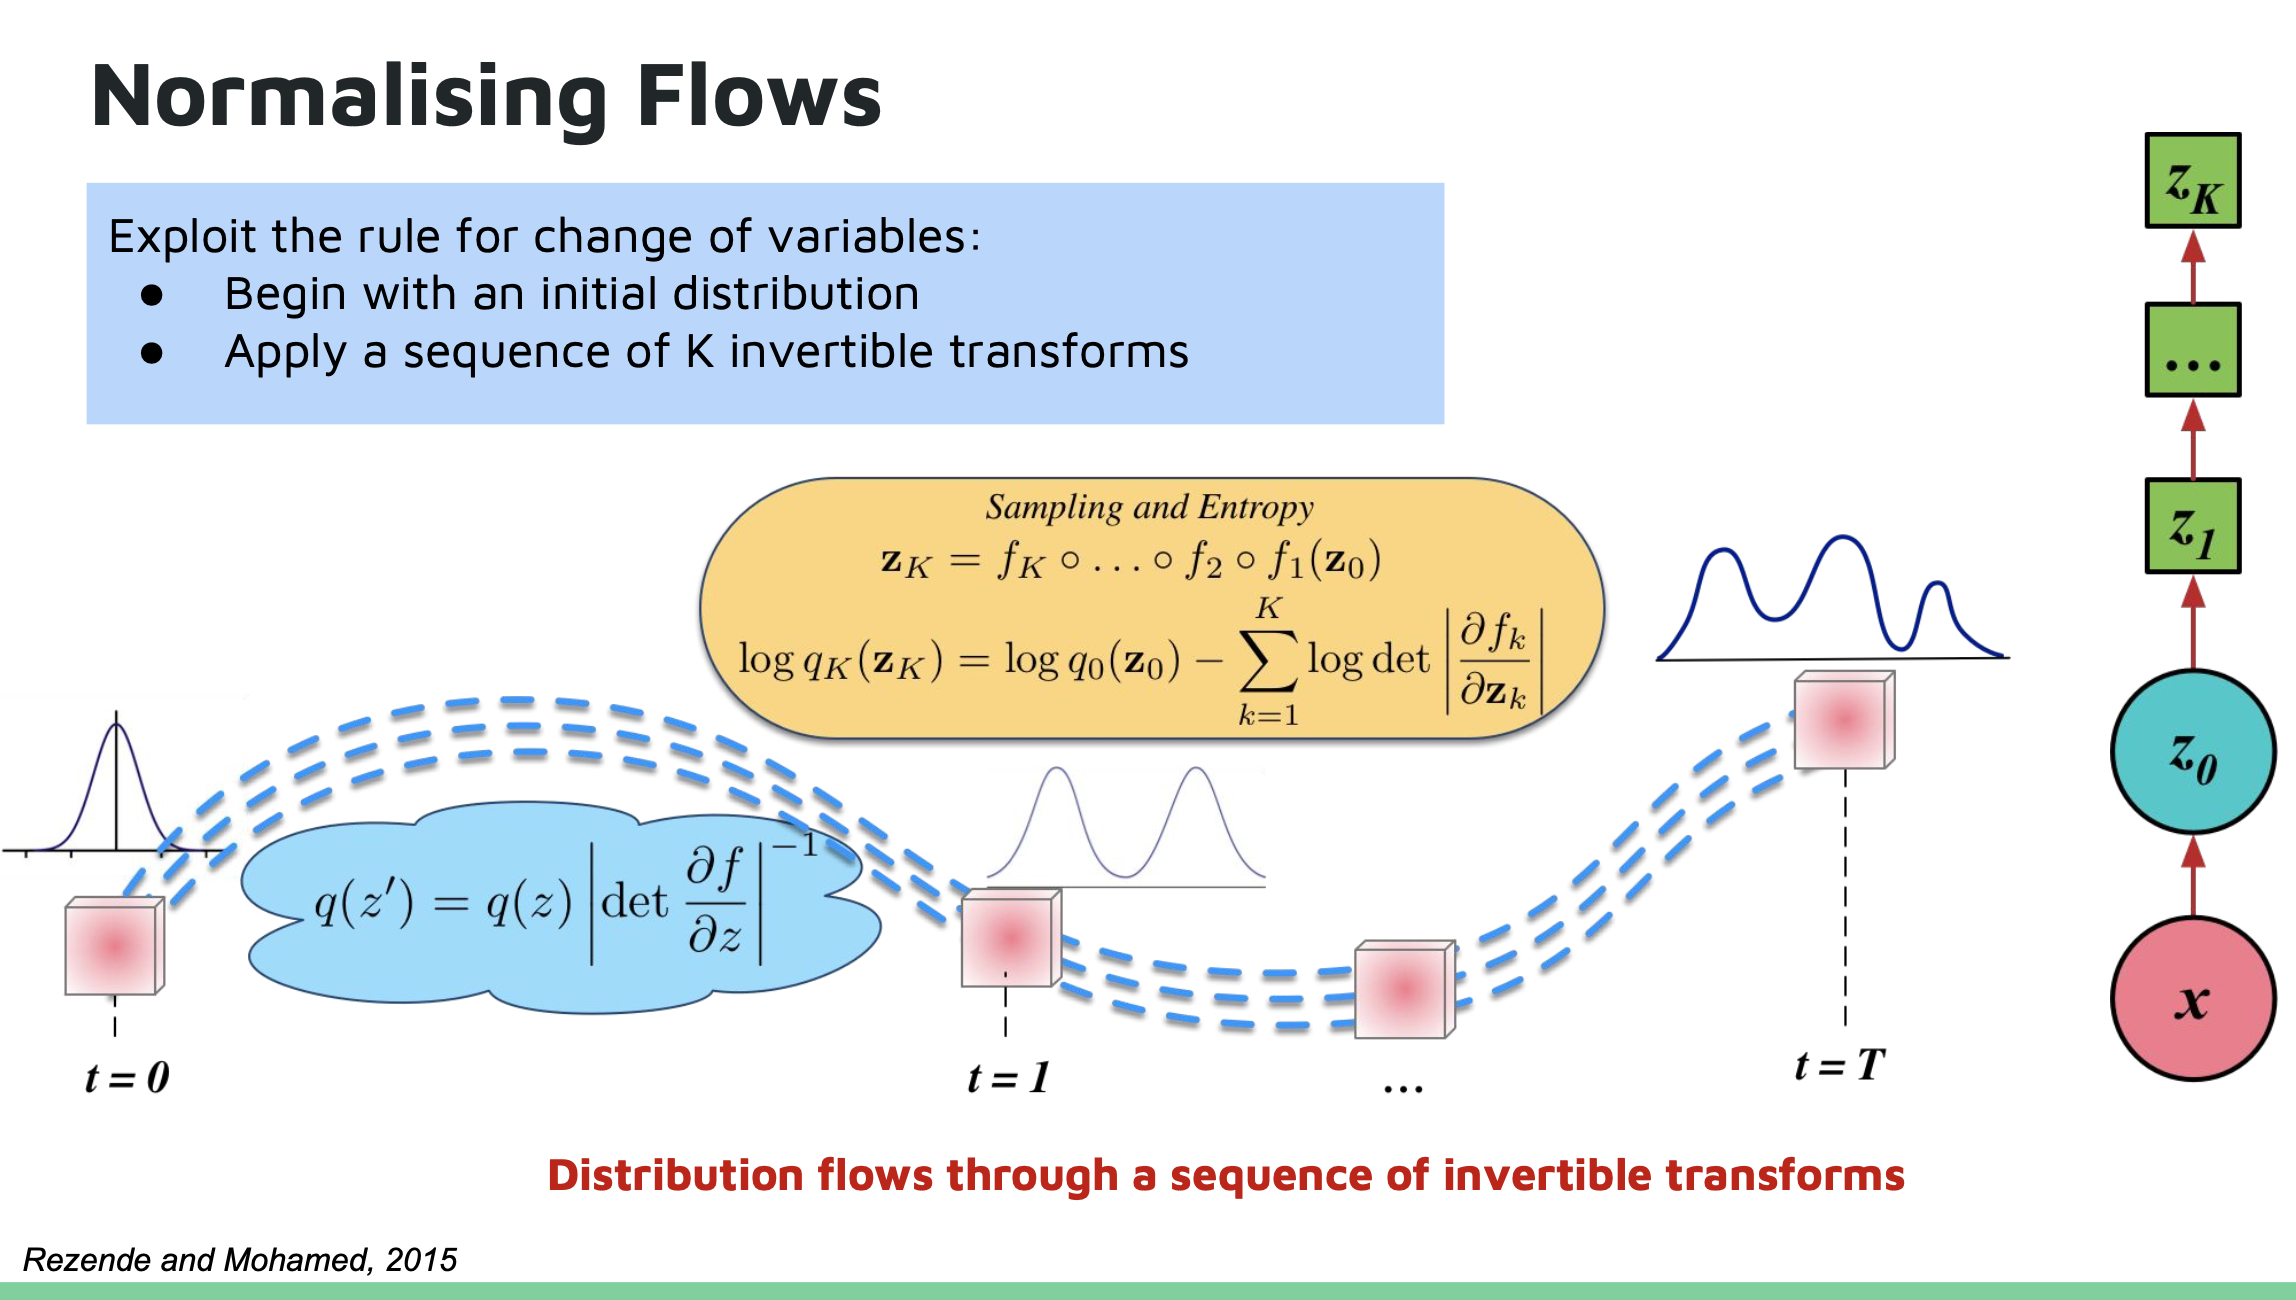

In [2]:
# Ref: UAI 2017 Deep Generative Models Workshop -> Rezende and Mohamed 
Image(filename='rezende_mohamed_uai.png') 

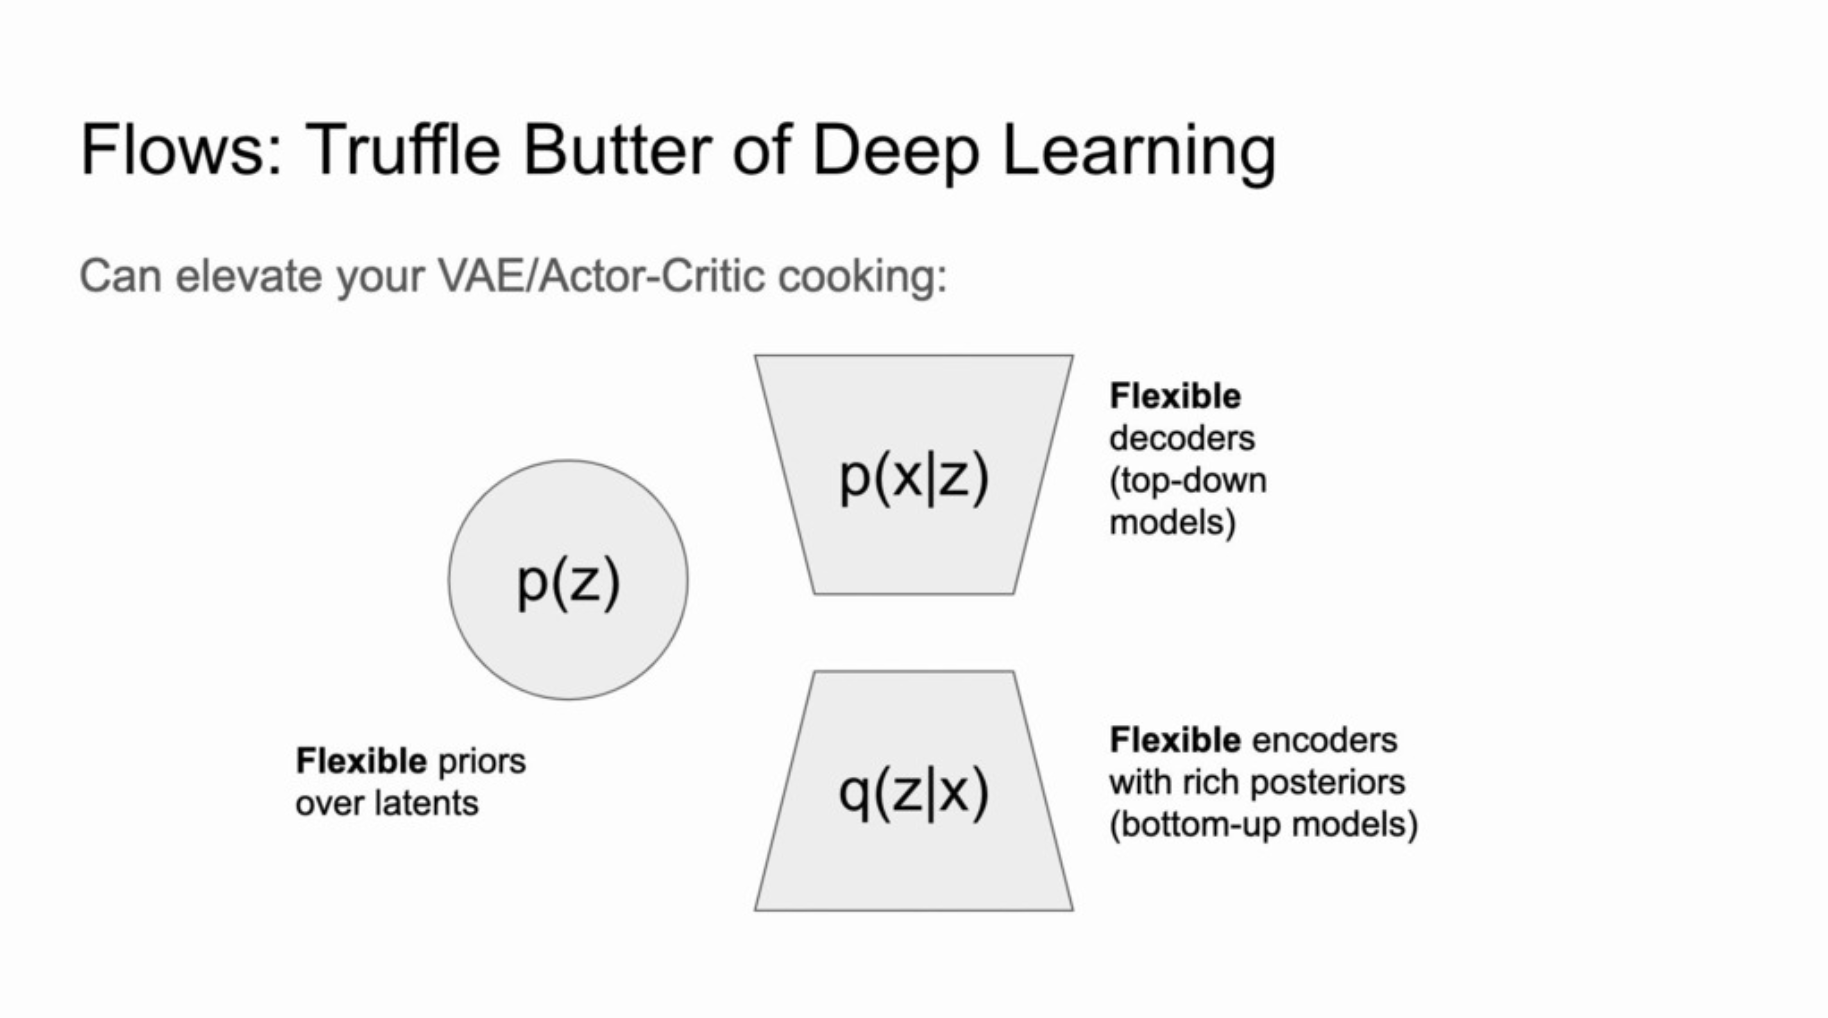

In [2]:
# https://slideslive.com/38917907/tutorial-on-normalizing-flows
from IPython.display import Image
Image(filename='truffle_butter.png') 

#### Some Background
Recall the change of variables formula with random variables given by a pdf, $ x \sim f_{X}(x)$, undergoing a transformation $y = g(x)$. The differential probability in an area is constant under a change of variables, $||f_{Y}(y)dy|| = ||f_{x}(x)dx||$. The consequence of this relationship helps determine the change of variables formula: $$f_{Y}(y) = | \frac{dx}{dy}| f_{X}(x) = | \frac{d}{dy}g^{-1}(y)|f_{x}(g^{-1}(y))$$

Let's take a look at an invertible transformation in 2d, it'll become more clear where the determinant comes from.

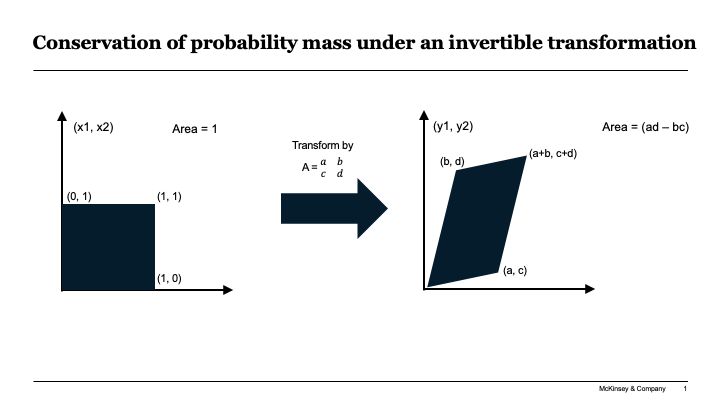

In [3]:
Image(filename='area_cons.png')

For simplicity, we can focus on the middle half of this equation, which reordering is $|\frac{dg^{-1}}{dx}|$. In multiple dimensions, the magnitude of this change is given by the determinant of the Jacobian of $g$ (the transformation between $y$ and $x$).

Here, the Jacobian matrix is the matrix of first derivatives, which defines the transformation. Taking a determinant is at worst case $O(n^3)$ operation, so we'll focus on finding transformations such that this operation is very quick, which is a major research area.
As a reminder the determinant of a 2 x 2 matrix A has a nice form $ \text{det(A)} = A_{00}A_{11}-A_{10}A_{01}$. For higher-dimensional matrices the formula becomes considerably more complex.


Next, let's see how we do this in code, and we'll leverage some of the functionality available in tensorflow probability.

### Example 1: Multivariate Gaussain, Affine Transformation
Fortunately, `tensorflow_probability` has a convenient construct to encapsulate transformations to use for building arbitrary flows. Remember, a chain of flows is still a flow!


In the next example, we'll walk through constructing a simple flow, eventually building up to something better.

#### Data
To test out our first idea, let's generate some 2d gaussian data. We stretch out the axes to make the distribution asymmetric. We'll also rotate the data by -45 degrees.

(-5.0, 5.0)

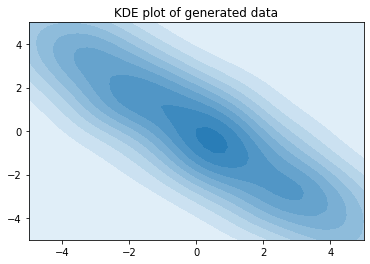

In [160]:
# Define a rotation matrix R
R = (1/np.sqrt(2))*np.array([[1, -1],[1, 1]])

# Define the covariance for our distribution
cov = np.eye(2)
cov[0,0] = 1
cov[1,1] = 25
x_rand = np.random.multivariate_normal(mean = np.zeros(2), cov = cov, size=(1000))

# Apply rotation
data = (R@x_rand.T).T

sns.kdeplot(data[:,0], data[:,1],shade=True)
plt.title('KDE plot of generated data')
plt.xlim([-5,5])
plt.ylim([-5,5])

#### TFP Model
Given an initial plot of the data, let's build out or flow. As motivation, let's try and model the density of the data. We'll create a parameterized distribution (the `TransformedDistribution` in `tensorflow_probability.distributions`). This requires specifying a base distribution, which we'll assume is simple. We can then learn the parameters of the transformations we can apply which maximize the probability of the data. Tensorflow probability calls these invertible transformations `bijectors`.

We'll need to be careful to make sure that the parameters are `tf.Variable` so that we can use the autograd functionality of tensorflow.


$$ y = Ax $$

In [65]:
affine_flow = tfp.bijectors.Chain(
    [        
     tfp.bijectors.Shift(tf.Variable(np.random.uniform(-.5, .5, size=(2)), 
                                     trainable=True, name='shift', dtype=tf.float64)),
    tfp.bijectors.ScaleMatvecTriL(tf.Variable(np.random.uniform(-.5, .5, size=(2,2)), 
                                              trainable=True, name='scale', dtype=tf.float64)),
    ], 
    name='affine_flow')

# Create the distribution object
affine_dist = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float64)),
    bijector=affine_flow)

In [55]:
# Make the loss function which will help us learn our parameters.
# We can evaluate the (log) probability of a sample/data point analytically since tfp.bijectors we're using 
# handle the calculation of the log determinant of the Jacobian for us :) .
@tf.function
def affine_loss(planar_inputs, planar_dist):
    return -tf.reduce_mean(planar_dist.log_prob(planar_inputs))

Let's view the shape and current values of the learnable variables

In [56]:
affine_dist.variables

(<tf.Variable 'shift:0' shape=(2,) dtype=float64, numpy=array([ 0.07341709, -0.00202065])>,
 <tf.Variable 'scale:0' shape=(2, 2) dtype=float64, numpy=
 array([[-0.17693221, -0.4954041 ],
        [ 0.08290522,  0.43453716]])>)

#### Train the model
Let's run a small training loop. Here we'll use the `tf.GradientTape` autograd functionality to simplify the overall process. This allows us to write arbitrary functions and optimize them, as long as they're differentiable.

In [67]:
iterations = 15000
optimizer = tf.optimizers.Adam(1e-3)

for i in range(iterations):
    with tf.GradientTape() as tape:
        loss = affine_loss(data, affine_dist)
    grads = tape.gradient(loss, affine_dist.trainable_variables )
    optimizer.apply_gradients(zip(grads, affine_dist.trainable_variables))

#### Check of what's learned
Let's check what exactly was learned, by looking at samples and the parameters of the model.

As a first check, let's look at the sample covariance of the data, and the sample covariance of samples from our learned distribution:

In [69]:
# Sample covariances: Check
np.cov(data.T), np.cov(affine_dist.sample(10000).numpy().T)

(array([[ 13.61902865, -12.67249895],
        [-12.67249895,  13.80840644]]),
 array([[ 13.6199127 , -12.67432742],
        [-12.67432742,  13.83651617]]))

Let's also look at the learned parameters of the models, our shift and affine scaling.

Q: What *should* they look like?

Answer to come shortly!

In [70]:
[x.numpy() for x in affine_dist.variables]

[array([ 0.02075671, -0.05035005]),
 array([[-3.68855116, -0.33753737],
        [ 3.4321949 , -1.41937881]])]

##### Aside: Generating Samples from a Normal

There's a fast way to generate a draws from a multi-variate normal with mean $mu$ and covariance matrix $\Sigma$:


$$x = \mu + \Sigma^{1/2}z, z \sim \mathcal{N}(\mathbb{0}, \mathbb{1})$$ 

As a check, we can work out the covariance of $x$ (let's assume :

$$
\begin{eqnarray}
cov(x,x) &= cov(\Sigma^{1/2}z, \Sigma^{1/2}z)\\
&= \Sigma^{1/2}z(\Sigma^{1/2}z)^T \\
&= \Sigma^{1/2}zz^T (\Sigma^{1/2})^{T} \\
&= \Sigma^{1/2} \mathbb{1} (\Sigma^{1/2})^{T} \\
&= \Sigma
\end{eqnarray}
$$

In [71]:
# First, a comparison of transformation operators
sigma_bij = affine_dist.variables[1].numpy()
flow_cov = (sigma_bij@sigma_bij.T)

# Let's calculate the (corresponding) symmetric sqrt of the covariance matrix (since this wasn't symmetric)
vals, vecs = np.linalg.eig(flow_cov)
flow_cov_sqrt = vecs.T@(np.diag(np.sqrt(vals)))@vecs

Now we can apply the rotation operator defined above to the original covariance matrix, which has close agreement with the derived, symmetric flow_cov_sqrt

In [72]:
flow_cov_sqrt, R.T@np.sqrt(cov)@R

(array([[3.16825885, 1.91871753],
        [1.91871753, 3.18011338]]),
 array([[3., 2.],
        [2., 3.]]))

As a last step, let's just plot samples from the learend `affine_dist`, so that we can visually compare to our generated data. Looks like some good agreement!

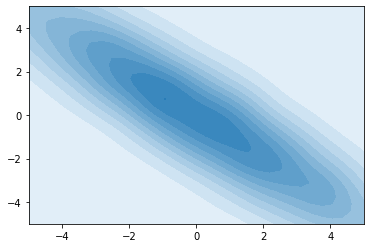

In [73]:
values = affine_dist.sample(10000)
y2 = values.numpy()
xlim, ylim = [-5, 5], [-5, 5]
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = sns.kdeplot(y2[:,0], y2[:,1],shade=True, ax=ax)
plt.show()

### Multivariate Gaussian, Simple Model
Let's use the same dataset, but move our bijetor to a keras model! We'll need to define our own custom bijector. This will show the methods we need to define in order for this to work clearly.

Let's use the same data here.

According to the docs, we'll need to define/override a forward, inverse, and inverse_log_determinant methods.

In [94]:
class AffineFlow(tfp.bijectors.Bijector):
    def __init__(self, validate_args=False,dim=2,name='affine flow'):
        super(AffineFlow, self).__init__(
        validate_args=validate_args,
        forward_min_event_ndims=0,
        name=name)
        self.dim = dim
        self.A = tf.Variable(np.random.uniform(0.5, 1., size=(dim,dim)), trainable=True, name='A', dtype=tf.float32)
        self.b = tf.Variable(np.random.uniform(-1., 1., size=(dim)), trainable=True, name='b', dtype=tf.float32)
    
    def _forward(self, z):
        """
        x = Az + b
        """
        return tf.transpose(tf.tensordot(self.A, tf.transpose(z), axes=1)) + self.b

    def _inverse(self, x):
        """
        z = A^{-1}(x-b)
        """
        return tf.transpose(tf.tensordot(tf.linalg.inv(self.A), tf.transpose(x-self.b), axes=1))

    
    def _inverse_log_det_jacobian(self, z):
        """
        det = self.A[0,0]*self.A[1,1] - self.A[1,0]*self.A[0,1]
        """
        det = self.A[0,0]*self.A[1,1] - self.A[1,0]*self.A[0,1]
        det = tf.expand_dims(tf.expand_dims(det,0),1)
        return -tf.math.log(det)


In [137]:
# Create the distribution object
affine_dist2 = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32)),
    bijector= AffineFlow())

In [138]:
iterations = 20000
optimizer = tf.optimizers.Adam(5e-4)

for i in range(iterations):
    with tf.GradientTape() as tape:
        loss = affine_loss(data.astype(np.float32), affine_dist2)
    grads = tape.gradient(loss, affine_dist2.trainable_variables )
    optimizer.apply_gradients(zip(grads, affine_dist2.trainable_variables))
    if i%1000 == 0:
        print(f"Iteration ={i}, loss = {loss}")

Iteration =0, loss = 175.62156677246094
Iteration =1000, loss = 28.922344207763672
Iteration =2000, loss = 18.01551628112793
Iteration =3000, loss = 13.574532508850098
Iteration =4000, loss = 11.11172103881836
Iteration =5000, loss = 9.54879093170166
Iteration =6000, loss = 8.48198413848877
Iteration =7000, loss = 7.715088844299316
Iteration =8000, loss = 7.129654884338379
Iteration =9000, loss = 6.638705730438232
Iteration =10000, loss = 6.197411060333252
Iteration =11000, loss = 5.936108589172363
Iteration =12000, loss = 5.838841438293457
Iteration =13000, loss = 5.790439128875732
Iteration =14000, loss = 5.769942283630371
Iteration =15000, loss = 5.763648509979248
Iteration =16000, loss = 5.762558460235596
Iteration =17000, loss = 5.762489318847656
Iteration =18000, loss = 5.762488842010498
Iteration =19000, loss = 5.762488842010498


In [139]:
sigma_bij = affine_dist2.variables[0].numpy()
flow_cov = (sigma_bij@sigma_bij.T)

# Let's calculate the (corresponding) symmetric sqrt of the covariance matrix (since this wasn't symmetric)
vals, vecs = np.linalg.eig(flow_cov)
flow_cov_sqrt = vecs.T@(np.diag(np.sqrt(vals)))@vecs
flow_cov_sqrt

array([[2.1648705, 1.4546494],
       [1.4546494, 2.1866086]], dtype=float32)

In [144]:
# empirical
np.cov(data.T), np.cov(affine_dist2.sample(10000).numpy().T)*2

(array([[ 13.61902865, -12.67249895],
        [-12.67249895,  13.80840644]]),
 array([[ 13.55472106, -12.59401117],
        [-12.59401117,  13.71983356]]))

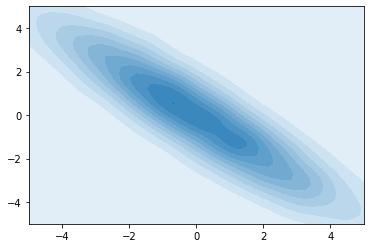

In [143]:
# Let's see what the samples look like!
y = affine_dist2.sample(10000).numpy()
xlim, ylim = [-5, 5], [-5, 5]
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = sns.kdeplot(y[:,0], y[:,1],shade=True)
plt.show()

### RealNVP

#### Introduction and formulation
Let's move on to something a bit more cutting-edge, Real-NVP, or [Real Non-Volume Preserving flows](https://arxiv.org/abs/1605.08803) (Dinh. et al. 2017).

As mentioned above, much of the work in flow research is designing a set of expressive transformations which are differentiable and have a computationally tractable (e.g. diagonal or lower-triangular) jacobian matrix, so that determinants are not difficult to calculate (naively they're $O(n^{3})$.

Mathematically, the flow defining Real-NVP splits our data domain, and models one component of the domain as a function of the other. Specifically,
$$
\begin{align}
y_{1:d} &= x_{1:d} \\
y_{d+1:D} &= x_{d+1:D} \odot \text{exp}(s(x_{1:d})) + t(x_{1:d}),
\end{align}
$$
where $\odot$ represents elementwise multiplication. The $s$ and $t$ operators represent a shift and a scale operator, and will be given by *neural networks*.

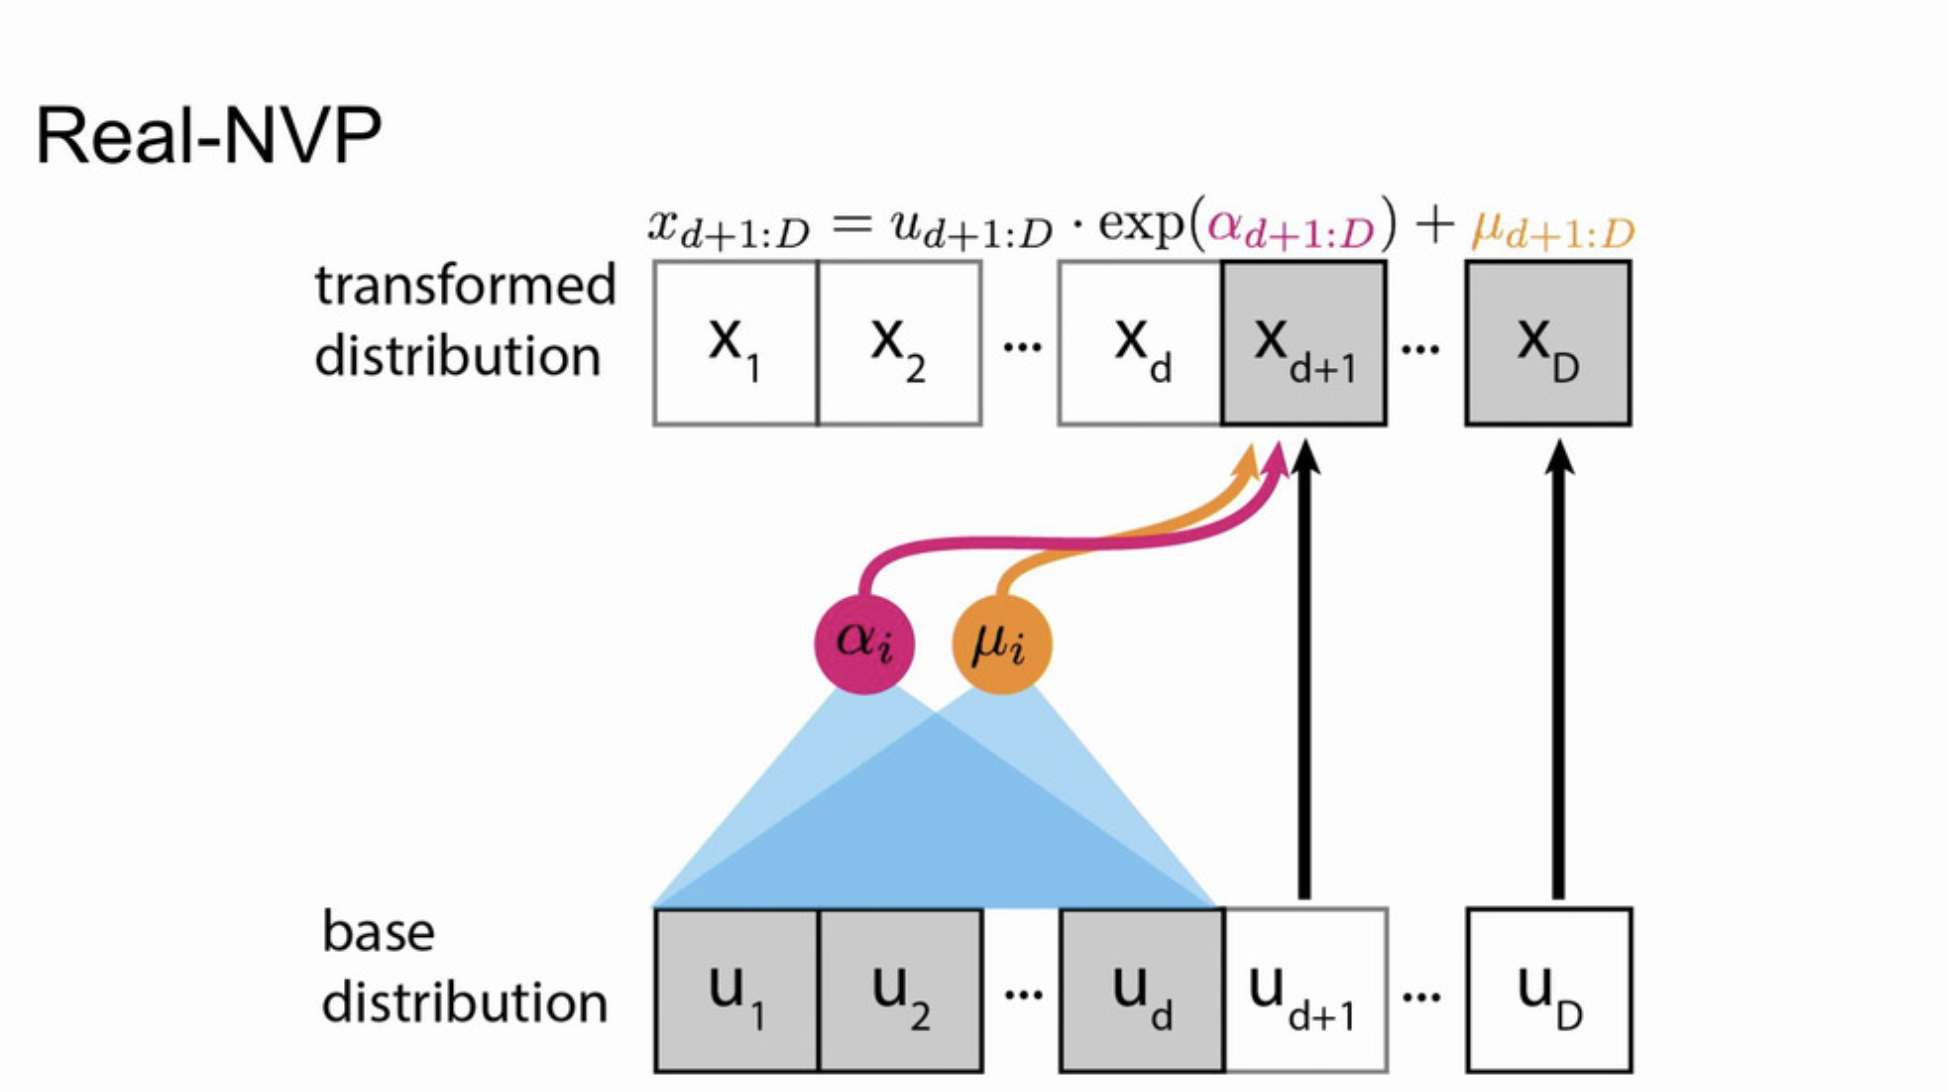

In [5]:
# Slide illustrating real-nvp
Image('real_nvp.png')

In terms of calculating the Jacobian, we'll cheat and I'll give it to you, but I'd encourage you to verify it's form yourself, it's a good exercise and reminder:

$$
\frac{\partial y}{\partial x^{T}} = \begin{bmatrix}
    \mathbb{I}_{d}       & 0 \\
        \frac{\partial y_{d+1:D}}{\partial x_{1:d}^{T}}       & \text{diag}( \text{exp}[s(x_{1:d})])
\end{bmatrix}.
$$

Here, $\text{diag}( \text{exp}[s(x_{1:d})])$ is a diagonal matrix. Notice how this is lower-diagonal, meaning that the determinant will be the product of the diagonal elements! That means then that:

$$
\text{det}(J) =|\frac{\partial y}{\partial x^{T}}| = \Pi_{j}\text{exp}[s(x_{1:d})] = \text{exp}[\sum_{j} s(x_{1:d})_j]
$$

The important thing to remember here is that the input and output of $s$ and $t$ network(s) must be the same size, but *internally* they can become very expressive by having hidden layers/features that are *much* larger in size, as we'll see.

Going further, remember that we'll often be working with *log* probabilities, and will want the forward-log-determinant of the jacobian. For the real-nvp model, this will be:
$$ 
\text{log}|\frac{\partial y}{\partial x^{T}}| = \sum_{j} s(x_{1:d})_j. $$

For the inverse, the ildj (inverse-log-determinant of the jacobian, we'll negate this.

#### Data
Before proceeding, if we'd like to use a more complex flow, it's worth checking out a more complex dataset. For this example, let's start with the half-moons dataset, seen below.

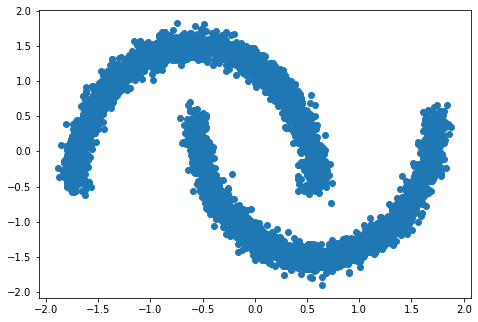

In [102]:
n_samples = 5000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(X[:,0], X[:,1])

#### Model
Let's build upon our custom `Bijector` definition that we worked out above for the affine transformation flow to this more challenging example. Let's make a network that's got a couple of larger hidden layers with `relu` activations.

In [103]:
class NVPBijector(tfp.bijectors.Bijector):
    def __init__(self, validate_args=False,dim=2, flip=False, name='real_NVP'):
        super(NVPBijector, self).__init__(
        validate_args=validate_args,
        forward_min_event_ndims=0,
        name=name)
        self.dim = dim
        # This is important so that the dimensions can be transformed. Without permutation, we'd only 
        # be applying this transformation to x (or y).
        self.flip = flip
        self.forward_model = self._build_model()
        
    def _build_model(self):
        model = tfk.Sequential()
        model.add(tfk.layers.Dense(512))
        model.add(tfk.layers.ReLU())
        model.add(tfk.layers.Dense(512))
        model.add(tfk.layers.ReLU())
        # In our 2d world, we need to predict the shift/translation and log scale/
        model.add(tfk.layers.Dense(self.dim))        
        return model
    
    def _forward(self, x):
        d = x.shape[-1]//2
        x1, x2 = x[...,:d], x[...,d:]
        if self.flip:
            x1, x2 = x2, x1
        # model_output is shift, log_scale
        model_output = self.forward_model(x1)
        shift, log_scale = tf.split(model_output, 2, axis=-1)
        y1 = x1
        # apply the forward formula above.
        y2 = tf.math.multiply(x2, tf.exp(log_scale)) + shift
        if self.flip:
            y1, y2 = y2, y1
        if len(y1.shape) == 1:
            y2 = tf.reshape(y2,[-1])
        if len(y2.shape) == 1:
            y1 = tf.reshape(y1,[-1])
            
        return tf.concat([y1, y2], axis=-1)

    def _inverse(self, y):
        d = y.shape[-1]//2
        y1, y2 = y[...,:d], y[...,d:]
        if self.flip:
            y1, y2 = y2, y1
        model_output = self.forward_model(y1)   
        shift, log_scale = tf.split(model_output, 2, axis=-1)
        x1 = y1
        # "Solve" for x from y.
        x2 = tf.math.multiply((y2-shift), tf.exp(-log_scale))
        
        if self.flip:
            x1, x2 = x2, x1
        x = tf.concat([x1, x2], axis=-1)
        return x
        
    
    def _inverse_log_det_jacobian(self, y):
        """
        When sub-classing tfp.Bijector to create custom bijectors, one needs to define either
        the _forward or _inverse_log_det_jacobian.
        """
        d = y.shape[-1]//2
        y1, y2 = y[...,:d], y[...,d:]
        if self.flip:
            y1 = y2
        model_output = self.forward_model(y1)   
        shift, log_scale = tf.split(model_output, 2, axis=-1)
        return -tf.reduce_sum(log_scale,axis=-1, keepdims=True)

Remember, a sequence of flows is, itself, a flow. Before we supplied a single bijector to the constructor of the transformed distribution, now let's supply a `chain` of bijectors, which will define a series of function compositions which are *all* learnable/differentiable. This might seem like overkill, but let's start with 8, so that each dimension has 4 transformations.

In [120]:
# We didn't see this be
mlp_bijector = tfp.bijectors.Chain(
    [NVPBijector(flip=False, name='layer0'),
    NVPBijector(flip=True, name='layer1'),
    NVPBijector(flip=False, name='layer2'),
    NVPBijector(flip=True, name='layer3'),
    NVPBijector(flip=False, name='layer4'),
    NVPBijector(flip=True, name='layer5'),
    NVPBijector(flip=False, name='layer6'),
    NVPBijector(flip=True, name='layer7'),
    ], 
    name='mlp_bijector')


dist = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32)),
    bijector=mlp_bijector)


In [121]:
# We can test the construction, to see that we can calculate log_prob of the transformed 
# distribution and the base distribution.
value_ = np_to_tf(np.array([[1,2],[10,20]]))
dist.log_prob(value_),dist.distribution.log_prob(value_)

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([   -4.2464733, -2390.4065   ], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([  -4.3378773, -251.83789  ], dtype=float32)>)

In [122]:
#let's make a keras model out of our transformed distribution so we can train it.
inputs = tfk.layers.Input(shape=2, dtype=tf.float32)
outputs = dist.log_prob(inputs)
model= tfk.Model(inputs, outputs)

In [123]:
model.compile(optimizer=tf.optimizers.Adam(0.00001),
              loss=lambda _, log_prob: -tf.reduce_mean(log_prob))

In [124]:
batch_size = 100
model.fit(x=X,
          y=np.zeros((n_samples, 0), dtype=np.float32),
          batch_size=batch_size,
          epochs=320,
          shuffle=True,
          verbose=1)

Epoch 1/320
50/50 [==============================] - 3s 65ms/step - loss: 2.4136
Epoch 2/320
50/50 [==============================] - 3s 62ms/step - loss: 1.8774
Epoch 3/320
50/50 [==============================] - 3s 62ms/step - loss: 1.7591
Epoch 4/320
50/50 [==============================] - 3s 67ms/step - loss: 1.7185
Epoch 5/320
50/50 [==============================] - 3s 55ms/step - loss: 1.6991
Epoch 6/320
50/50 [==============================] - 3s 57ms/step - loss: 1.6788
Epoch 7/320
50/50 [==============================] - 4s 74ms/step - loss: 1.6568
Epoch 8/320
50/50 [==============================] - 3s 67ms/step - loss: 1.6329
Epoch 9/320
50/50 [==============================] - 3s 63ms/step - loss: 1.6027
Epoch 10/320
50/50 [==============================] - 3s 69ms/step - loss: 1.5672
Epoch 11/320
50/50 [==============================] - 3s 69ms/step - loss: 1.5232
Epoch 12/320
50/50 [==============================] - 3s 57ms/step - loss: 1.4674
Epoch 13/320
50/50 [=====

50/50 [==============================] - 2s 34ms/step - loss: 0.6560
Epoch 102/320
50/50 [==============================] - 2s 39ms/step - loss: 0.6450
Epoch 103/320
50/50 [==============================] - 2s 35ms/step - loss: 0.6452
Epoch 104/320
50/50 [==============================] - 2s 32ms/step - loss: 0.6410
Epoch 105/320
50/50 [==============================] - 1s 29ms/step - loss: 0.6414
Epoch 106/320
50/50 [==============================] - 2s 34ms/step - loss: 0.6366
Epoch 107/320
50/50 [==============================] - 1s 28ms/step - loss: 0.6389
Epoch 108/320
50/50 [==============================] - 1s 30ms/step - loss: 0.6410
Epoch 109/320
50/50 [==============================] - 2s 32ms/step - loss: 0.6473
Epoch 110/320
50/50 [==============================] - 2s 35ms/step - loss: 0.6378
Epoch 111/320
50/50 [==============================] - 2s 32ms/step - loss: 0.6387
Epoch 112/320
50/50 [==============================] - 2s 33ms/step - loss: 0.7022
Epoch 113/320
50/5

50/50 [==============================] - 2s 35ms/step - loss: 0.1293
Epoch 298/320
50/50 [==============================] - 2s 32ms/step - loss: 0.1373
Epoch 299/320
50/50 [==============================] - 2s 34ms/step - loss: 0.1117
Epoch 300/320
50/50 [==============================] - 2s 36ms/step - loss: 0.1127
Epoch 301/320
50/50 [==============================] - 2s 33ms/step - loss: 0.1686
Epoch 302/320
50/50 [==============================] - 2s 34ms/step - loss: 0.2200
Epoch 303/320
50/50 [==============================] - 2s 35ms/step - loss: 0.1180
Epoch 304/320
50/50 [==============================] - 2s 34ms/step - loss: 0.1148
Epoch 305/320
50/50 [==============================] - 2s 35ms/step - loss: 0.1113
Epoch 306/320
50/50 [==============================] - 2s 34ms/step - loss: 0.1207
Epoch 307/320
50/50 [==============================] - 2s 34ms/step - loss: 0.1409
Epoch 308/320
50/50 [==============================] - 2s 32ms/step - loss: 0.0958
Epoch 309/320
50/5

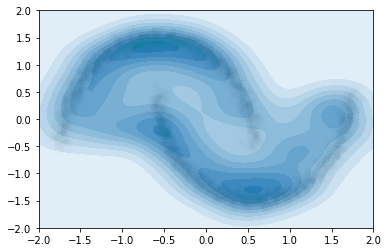

In [146]:
# Let's plot a kde plot of our samples, we can see some noise in the left qudrant, but by and large we recover our original data!
values = dist.sample(1000)
y2 = values.numpy()
xlim, ylim = [-2, 2], [-2, 2]
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = sns.kdeplot(y2[:,0], y2[:,1],shade=True, ax=ax)
ax.scatter(X[:,0], X[:,1], color = 'green', alpha=0.005)


plt.show()

### Sampling from a more complex distribution
As we've seen, Normalizing Flows are quite-powerful models (and are *highly* parameterized).

To test out their capabilities, let's generate another dataset, this time from an *image*!

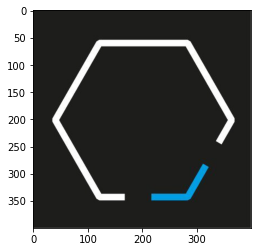

In [147]:
img_data = PIL.Image.open('qb.jpg')
img_arr = np.array(img_data) 
plt.imshow(img_arr)

In [148]:
# Filter out low values, make background uniform,
img = np.sum(img_arr, axis=2)*1.
img[img<100] =0
img[img>300] = 300
img[(img>=100) & (img <=300)] = 250
img = img[:-1,:-1]
img /= np.sum(img)

In [149]:
# boiler plate code for sampling
dims = img.shape[0]
pairs=np.indices(dimensions=(dims,dims)).T # here are all of the x,y pairs 
# make n random selections from the flattened pmf without replacement
# whether you want replacement depends on your application
n=5000 
inds=np.random.choice(np.arange(dims**2),p=img.reshape(-1),size=n,replace=False)

# inds is the set of n randomly chosen indicies into the flattened dist array...
# therefore the random x,y selections
# come from selecting the associated elements
# from the flattened pairs array
selections = pairs.reshape(-1,2)[inds]

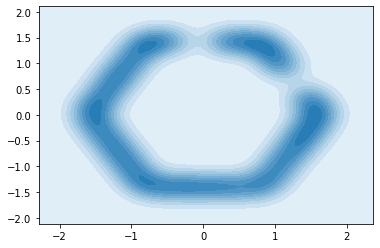

In [150]:
# Let's plot our samples
pts = (selections)/100
pts -= 2.
sns.kdeplot(pts[:,0], pts[:,1],shade=True)

For this more complicated distribution, let's chain a few more bijectors together. :) Now each dimension get's processed 5 times.

In [151]:
# Last layer is affine. Note that tfb.Chain takes a list of bijectors in the *reverse* order
# that they are applied.
qb_bijector = tfp.bijectors.Chain(
    [NVPBijector(flip=False, name='layer0'),
    NVPBijector(flip=True, name='layer1'),
    NVPBijector(flip=False, name='layer2'),
    NVPBijector(flip=True, name='layer3'),
    NVPBijector(flip=False, name='layer4'),
    NVPBijector(flip=True, name='layer5'),
    NVPBijector(flip=False, name='layer6'),
    NVPBijector(flip=True, name='layer7'),
    NVPBijector(flip=False, name='layer8'),
    NVPBijector(flip=True, name='layer9'),
     
    ], 
    name='qb_bijector')


qb_dist = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32)),
    bijector=qb_bijector)


In [152]:
#Let's again make a keras model to train our parameters (a clever hack)
qb_inputs = tfk.layers.Input(shape=2, dtype=tf.float32)
qb_outputs = qb_dist.log_prob(qb_inputs)
qb_model= tfk.Model(qb_inputs, qb_outputs)

In [153]:
# Kind of a crazy situation -> we're fitting a very parameterized model!
qb_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_138 ( [(None, 1)]          0           input_4[0][0]                    
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, 2)            264706      tf_op_layer_strided_slice_138[0][
                                                                 tf_op_layer_strided_slice_159[0][
__________________________________________________________________________________________________
tf_op_layer_split_48 (TensorFlo [(None, 1), (None, 1 0           sequential_24[0][0]   

In [154]:
qb_model.compile(optimizer=tf.optimizers.Adam(0.000001),
              loss=lambda _, log_prob: -tf.reduce_mean(log_prob))

In [157]:
batch_size = 500
qb_model.fit(x=pts,
          y=np.zeros((pts.shape[0], 0), dtype=np.float32),
          batch_size=batch_size,
          epochs=6000,
          shuffle=True,
          verbose=0)

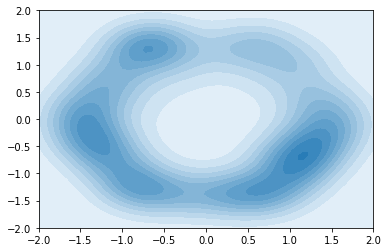

In [158]:
y = qb_dist.sample(500).numpy()
xlim, ylim = [-2, 2], [-2, 2]
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = sns.kdeplot(y[:,0], y[:,1],shade=True, ax=ax)

plt.show()

In [159]:
test_point = np_to_tf(np.array([1., -1.25]).reshape((1,2)))
tf.exp(qb_dist.log_prob(test_point))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([10.454162], dtype=float32)>

### References
1) https://invertibleworkshop.github.io/INNF_2019/schedule/index.html
2) https://www.shakirm.com/slides/DeepGenModelsTutorial.pdf

### Appendix: Planar Flows
Here we'll build a custom class implementing a planar flow, then use the native tensorflow probability bijectors to check our implementation!

Some math the planar flow is defined as : $x = \mathbf{z} + \mathbf{u} h(w^{T}z + b)$
The determinant of this transformation is then $\frac{dx}{dz} = |1+h'(w^{T}z+b)u^{T}w|$

In [7]:
class PlanarFlow(tfp.bijectors.Bijector):
    def __init__(self, validate_args=False,dim=2,name='real_NVP'):
        super(PlanarFlow, self).__init__(
        validate_args=validate_args,
        forward_min_event_ndims=0,
        name=name)
        self.dim = dim
        self.w = tf.Variable(np.random.uniform(-1., 1., size=(dim)), trainable=True, name='w', dtype=tf.float64)
        self.u = tf.Variable(np.random.uniform(-1., 1., size=(dim)), trainable=True, name='u', dtype=tf.float64)
        self.b = tf.Variable(np.random.uniform(-1., 1., size=(1)), trainable=True,name='b', dtype=tf.float64)
    
    def _forward(self, z):
        zw = tf.tensordot(z, self.w, axes=1)
        x = z + tf.tensordot(tf.tanh( zw + self.b), self.u, axes=0)
        return x

    def _inverse(self, x):
        xw = tf.tensordot(x, self.w, axes=1)
        z = x + tf.tensordot(tf.tanh(xw + self.b), self.u, axes=0)
        return z

    
    def _inverse_log_det_jacobian(self, z):
        zw = tf.tensordot(z, self.w, axes=1)
        psi = 1. - tf.pow(tf.tanh(zw+self.b),2)
        det = 1 + psi* tf.tensordot(self.u,self.w, axes=1)
        det = tf.expand_dims(det,1)
        return -tf.math.log(tf.abs(det))
